<a href="https://colab.research.google.com/github/danielsaggau/Elections-Belarus/blob/main/Belarus_ML_Full_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleansing 

In the first part of this analysis, we need to undertake some pre-processing steps. 


In [1]:
import pandas as pd
import numpy as np
df_pls=pd.read_excel("df_merge_n.xlsx")

In [ ]:
df_pls_pls=df_pls.drop(columns=['Unnamed: 0'])
df_pls_pls=df_pls_pls.fillna(0)
df_pls_new=df_pls_pls.drop(columns=['commission_code','number_of_cite'])
df_pls_new.info()

In [ ]:
df_merge1=df_pls_new.drop(columns=['attachment1','attachment2','attachment3','attachment4','attachment5','comment','id','type','name','location','origin','area'])
df_merge1.info()

# Feature Engineering 
We can now calculate the share of votes for Lukashenko. 

In [ ]:
df_merge1['lukashenko_share']=df_merge1['Lukashenko']/df_merge1['number_of_voters_who_took_part_in_the_voting']
df_merge1['lukashenko_share']=df_merge1['lukashenko_share'].replace([np.inf, -np.inf], 0)
df_merge1.info()

Now, we can drop some of the obsolete columns. 

In [5]:
df_merge2=df_merge1.drop(columns=['parent_id','description_x','commission_id','work_title','description_y','city_or_district_within_the_region','area_in_the_city','settlement'])

In [ ]:
df_merge2.columns

In [ ]:
df_merge2['region'].unique()

Next we need to rename the regions and introduce a variable for observations with no region: 

In [8]:
df_merge2['region']=df_merge2['region'].replace('Брестская','brestskaya')
df_merge2['region']=df_merge2['region'].replace('Витебская','vitebskaya')
df_merge2['region']=df_merge2['region'].replace('Гомельская','gomelskaya')
df_merge2['region']=df_merge2['region'].replace('Гродненская','grodnenskaya')
df_merge2['region']=df_merge2['region'].replace('Минская','miskaya')
df_merge2['region']=df_merge2['region'].replace('Могилевская','mogilevskaya')
df_merge2['region']=df_merge2['region'].replace('город Минск','minsk')
df_merge2.region=df_merge2.region.replace(0, 'no_region')

Based on this variable, we can craete dummy variables for each region. 

In [9]:
df_merge_d=df_merge2.fillna(0)
df_merge_d.to_excel("df_merge_d.xlsx") #Optional Step: Saving file without region dummies

In [10]:
df_merge3=pd.get_dummies(df_merge2, 'region')

We can save this dataset as an intermediate dataset.
We also save a version without the region dummies for the regression analysis thereafter, due to the limited number of observations for some regions that could become problematic later on.

In [ ]:
df_merge3.info()
df_merge3=df_merge3.fillna(0)
df_merge3.to_excel("df_merge_3.xlsx") # Save file with dummies

# Random Forest for Feature Selection 

In this section we use a random forest for feature selection.
This section is structured as follows:

1. Specifying our model structure and removing variables that are not needed or variables that should be included for the prediction  
2. Splitting the data set into training and test set 
3. Running the algorithm, using cross validation
4. Plot the feature importance per feature 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

# Splitting the Dataset and specifying our dependent Variable



In [14]:

# обязательный код
X=df_merge3.drop(columns=['lukashenko_share','Dmitriev','Kanopatskaya','Lukashenko','Tikhanovskaya','Cherechen']).values
y=df_merge3.lukashenko_share.values
# сплитуйте X и y как хотите
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, 
                                                    shuffle=True)

Next we can instantiate our RF regressor.

In [ ]:
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1600, num = 8)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 90, num = 9)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [17]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [18]:
rf_random.best_params_
y_pred=rf_random.predict(X_test)
print('Правильность на обучающем наборе: {:.5f}'.format(rf_random.score(X_train, y_train)))
print('Правильность на тестовом наборе: {:.5f}'.format(rf_random.score(X_test, y_test)))

Правильность на обучающем наборе: 0.94207
Правильность на тестовом наборе: 0.60561


In [19]:
importance_values=rf_random.best_estimator_.feature_importances_

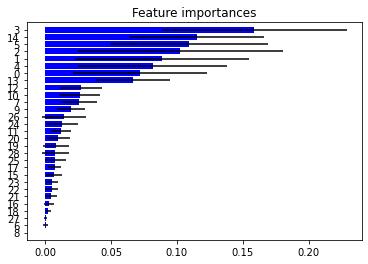

In [20]:
importances = rf_random.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [21]:
feature_importance_labels=df_merge3.drop(columns=['lukashenko_share','Dmitriev', 'Kanopatskaya', 'Lukashenko', 'Tikhanovskaya', 'Cherechen'])

In [22]:
column_names=list(feature_importance_labels.columns)

In [23]:
column_names

['total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election',
 'number_of_voters_who_received_ballots',
 'number_of_voters_who_took_part_in_the_voting',
 'number_of_voters_who_took_part_in_the_early_voting',
 'number_of_voters_who_took_part_in_voting_at_the_place_of_residence',
 'number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station',
 'number_of_votes_for_candidates_who_dropped_out_during_early_voting_period',
 'number_of_votes_againts_all_candidates',
 'number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate',
 'number_of_ballots_declared_invalid',
 'number_of_ballots_received_by_election_commission',
 'number_of_spoiled_ballots',
 'number_of_unused_ballots',
 'latitude',
 'longitude',
 'doctor',
 'army',
 'education',
 'science',
 'prof_union',
 'economics',
 'region_brestskaya',
 'region_gomelskaya',
 'region_grodnenskaya',
 'region_minsk',
 'region_miskaya',
 'region_mogile

In [24]:
values_imp=list(importance_values)

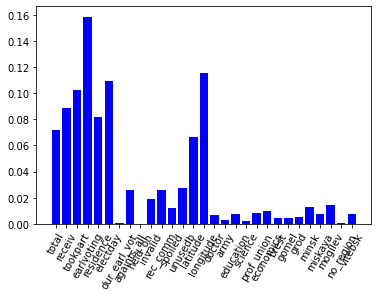

In [25]:
import numpy as np
import matplotlib.pyplot as plt 
 
courses = ['total','receiv','tookpart','earlvoting','residence','electday','dur_earl_vot','againts_all','held_on','invalid','rec_comm','spoiled','unusedb','latitude','longitude','doctor','army','education','science','prof_union','economics','brest','gomel', 'grod','minsk','miskaya','mogilev','no_region','vitebsk']
values = values_imp

plt.bar(courses, values, color ='blue')

plt.xticks(rotation = 60)
plt.show()

In [26]:
df_merge3.isna().sum()

total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election    0
number_of_voters_who_received_ballots                                                                                       0
number_of_voters_who_took_part_in_the_voting                                                                                0
number_of_voters_who_took_part_in_the_early_voting                                                                          0
number_of_voters_who_took_part_in_voting_at_the_place_of_residence                                                          0
number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station                                         0
Dmitriev                                                                                                                    0
Kanopatskaya                                                                                                          


#  Data Analysis in R
We undertake the regression models in R. 
The following sections are structured as follows: 

1.   Lasso Regression versus Naive Regression model
> *  Splitting the Data
> *  Correlation Plot
> * Skimming the Dataset
> * Naive Regression Model 
> * Lasso Regression Model 
> * Cross Validation 
> * MSE for Prediction on Test and Training Data 
> * Feature Importance Lasso Model 
2.   Regression model with the selected features for LASSO
> * Evaluation and Considerations
3.   Exploration of unsupervised learning methods Part 1: Principal Component Analysis 
> * PCA Analysis 
> * Screeplot 
> * Further Considerations future Research 
4.   Exploration of unsupervised learning methods Part 2: Latent Dirichlet Allocation 
> * Data Cleaning for Text Data 
> * Topic Model with VEM 
> * Topic Model with Gibbs Sampling
> * Considerations and Shortcomings for further research 

5.   Geospatial Analysis of Voting Behaviour 
> * Total Voting Behaviour across regions 
> * Share of Votes for Lukashenko 
> * Looking at previous election year (1994) 

Prior to including R code, we need to install 'rpy2' package.
Further, every cell needs to start with %%R for the Markdown file to differentiate between R code and Python code.

## 1. Lasso Regression versus Naive Regression model 

In [ ]:
!pip install rpy2
%load_ext rpy2.ipython

## LASSO Regression for Feature Selection

In the first step we need to install our packages and set our seed for replicability.

In [ ]:
%%R
install.packages("skimr")
install.packages("glmnet")
install.packages("plotmo")
library(readxl)
library(MASS)
library(tidyverse)
library(broom)
library(skimr)
library(glmnet)
library(plotmo)
set.seed(144)

## Splitting the data 

In the first step, we split the data into training and test set. 
We use a split of 0.66.
For reference, we are using a slightly modified dataset here because we use regression as a categorical variable and not use dummies for each region due to the limited number of observations which prove to be inconvient for subsequent regression analysis. Irrespective, we will later on look at geospatial voting information to get a more fine grained picture of what the geospatial variation looks like. 

In [ ]:
%%R
set.seed(123)
data = read_excel("df_merge_3.xlsx")
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen","...1")) # removing other candidate votes
skim(data)

In [103]:
%%R

data = data %>%
rename(
    total = total_number_of_voters_at_the_polling_station_determined_by_the_list_of_citizens_entitled_to_participate_in_the_election,
received = number_of_voters_who_received_ballots,
took_part = number_of_voters_who_took_part_in_the_voting,
part_early = number_of_voters_who_took_part_in_the_early_voting,
part_residence = number_of_voters_who_took_part_in_voting_at_the_place_of_residence,
part_electionday =number_of_voters_who_took_part_in_the_voting_on_election_day_at_the_polling_station, 
dropped = number_of_votes_for_candidates_who_dropped_out_during_early_voting_period,
against_all = number_of_votes_againts_all_candidates,
against_single = number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate,
invalid = number_of_ballots_declared_invalid,
commission = number_of_ballots_received_by_election_commission,
spoiled = number_of_spoiled_ballots,
unused = number_of_unused_ballots
)
data = data[c(23:30,1:22)] # reorder variables

In [104]:
%%R
data = data %>%
na.omit(lukashenko_share ==0)
summary(data)

 region_brestskaya region_gomelskaya region_grodnenskaya  region_minsk   
 Min.   :0.0000    Min.   :0.00000   Min.   :0.000       Min.   :0.0000  
 1st Qu.:0.0000    1st Qu.:0.00000   1st Qu.:0.000       1st Qu.:0.0000  
 Median :0.0000    Median :0.00000   Median :0.000       Median :0.0000  
 Mean   :0.1238    Mean   :0.08528   Mean   :0.127       Mean   :0.3001  
 3rd Qu.:0.0000    3rd Qu.:0.00000   3rd Qu.:0.000       3rd Qu.:1.0000  
 Max.   :1.0000    Max.   :1.00000   Max.   :1.000       Max.   :1.0000  
 region_miskaya   region_mogilevskaya region_no_region   region_vitebskaya
 Min.   :0.0000   Min.   :0.00000     Min.   :0.000000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.00000     1st Qu.:0.000000   1st Qu.:0.00000  
 Median :0.0000   Median :0.00000     Median :0.000000   Median :0.00000  
 Mean   :0.1889   Mean   :0.07454     Mean   :0.002527   Mean   :0.09792  
 3rd Qu.:0.0000   3rd Qu.:0.00000     3rd Qu.:0.000000   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.0000

In [105]:
%%R
p = ncol(data) -1
n <- nrow(data)
ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 

Now we can also look at some summary statistics.
Optionally, we can also look at summary statistics itself using the summary command, but some recent data exploration packages allow for a more interesting look at different variables also plotting 

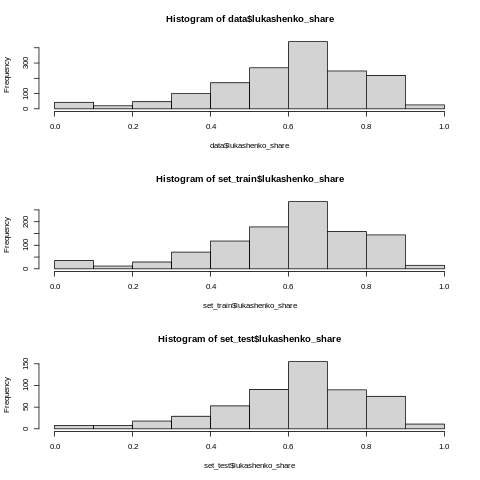

In [106]:
%%R
par(mfrow = c(3, 1))
hist(data$lukashenko_share) 
hist(set_train$lukashenko_share)
hist(set_test$lukashenko_share)

In [107]:
%%R
skim(data)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1583  
Number of columns          30    
_______________________          
Column type frequency:           
  numeric                  30    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable       n_missing complete_rate       mean        sd    p0
 1 region_brestskaya           0             1    0.124      0.329    0  
 2 region_gomelskaya           0             1    0.0853     0.279    0  
 3 region_grodnenskaya         0             1    0.127      0.333    0  
 4 region_minsk                0             1    0.300      0.458    0  
 5 region_miskaya              0             1    0.189      0.392    0  
 6 region_mogilevskaya         0             1    0.0745     0.263    0  
 7 region_no_region            0             1    0.0

## Correlation Plot

Next we can also look at the correlation plot

In [ ]:
%%R
install.packages("corrplot")
library(corrplot)

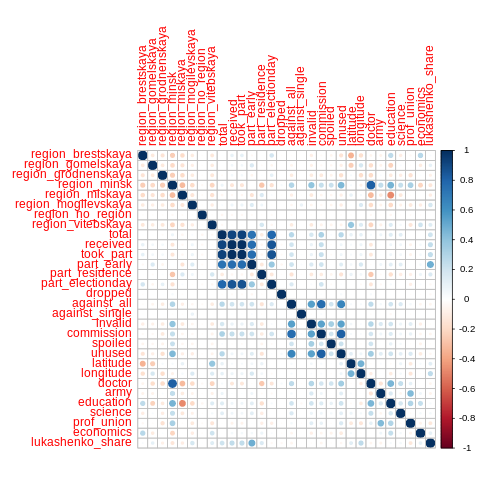

In [108]:
%%R
correl = cor(data)
corrplot(correl)

There are two correlation-conglomerations. One, between the unused, spoiled 

# Naive Regression Model

We can already see that some features have too few observations and cannot be defined. 
Technically, we could also include these features but the lasso regression will also exclude them later on regardless. Further, get a decent R^2 score but also deal with many different features that might be redunant and also remmain insignificant.
 This might also be the case due to the correlation between features, implying that if features are highly correlated, either the one or the other feature adds variance while the other feature adds little explanatory power as the features explain the same thing. Henceforth, we can use a feature selection method, again.  

In [109]:
%%R
model_naive = lm(lukashenko_share~., data = set_train)
summary(model_naive)


Call:
lm(formula = lukashenko_share ~ ., data = set_train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.50124 -0.08725  0.00772  0.08911  0.45996 

Coefficients: (2 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          2.603e-01  3.286e-01   0.792 0.428442    
region_brestskaya    4.619e-03  2.710e-02   0.170 0.864710    
region_gomelskaya   -5.707e-02  3.053e-02  -1.870 0.061827 .  
region_grodnenskaya -4.309e-02  2.322e-02  -1.855 0.063827 .  
region_minsk        -1.338e-01  3.620e-02  -3.696 0.000231 ***
region_miskaya      -3.986e-02  2.303e-02  -1.731 0.083767 .  
region_mogilevskaya  9.720e-04  2.703e-02   0.036 0.971319    
region_no_region    -4.177e-03  8.969e-02  -0.047 0.962858    
region_vitebskaya           NA         NA      NA       NA    
total               -2.127e-06  2.953e-05  -0.072 0.942602    
received             3.111e-05  5.620e-05   0.554 0.579954    
took_part           -4.8

# Lasso Model

As mentioned, we want to induce more sparcity and therefore can use a lasso regression model. For our lasso model, we need to determine our optimal lambda parameter, our trade off between variance and bias. 
Next we need to set up our lasso model.
We need to use the glmnet package and define our training set as a matrix (excluding our dependent variable). 

In [139]:
%%R
model_lasso = glmnet(x = as.matrix(set_train[,-(p+1)]), y = set_train$lukashenko_share, alpha =1)

## Cross Validation 

Next we can determine our trade-off parameter lambda, which is used to balance bias and variance. 
We can plot log(lambda) versus MSE for various degrees of freedom. We use the same number of folds as for the random forest (3).

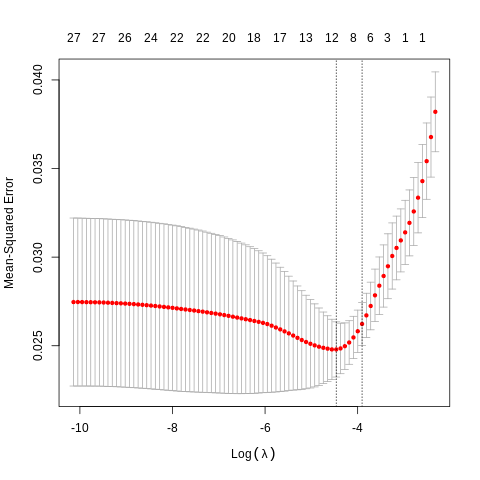

In [202]:
%%R
cv<-cv.glmnet(as.matrix(set_train[-(p+1)]), y= set_train$lukashenko_share,alpha =1, nfolds = 3) 
plot(cv)

## Selecting the optimal Lambda parameter

We pick the lambda parameter by taking the smallest lambda via lambda.min. Further, we can plot how the coefficents change with different lambda vlues. Here can see that the covariates converge differently to zero with various log lambda parameters. 

[1] 0.009572031


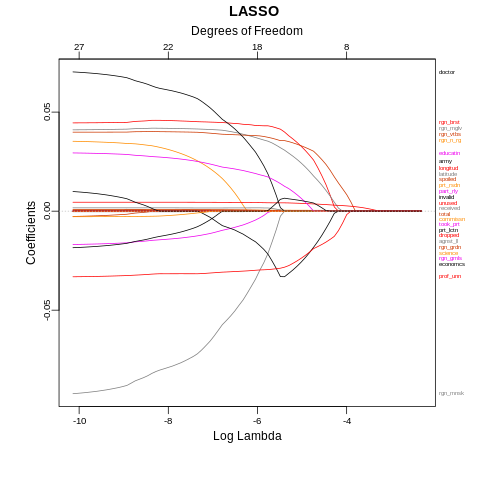

In [162]:
%%R
# Select minimum lambda
lambda_lasso = cv.glmnet(x = as.matrix(set_train[,-(p+1)]),y = set_train$lukashenko_share, alpha =1)$lambda.min
lambda_lasso
# Plot log lambda
plot_glmnet(x = model_lasso, label = TRUE, xvar = "lambda")
title(main = "LASSO", line = 3)

## Optional : More Iterations 
This step is optional. 
We can optionally also run various cross validation splits. Here we do 100 iterations. 

In [145]:
%%R
MSEs <- NULL
for (i in 1:100){
                 cv= cv.glmnet(x= as.matrix(set_train[,-(p+1)]), y= set_train$lukashenko_share, alpha =1) 
                 MSEs <- cbind(MSEs, cv$cvm)
             }
  rownames(MSEs) <- cv$lambda
  lambda.min <- as.numeric(names(which.min(rowMeans(MSEs))))
  lambda.min

[1] 0.009572031



We can first look at how our models perform on our training data.
Here we are comparing a random forest and a lasso model. 

## Prediction on Training Data

In [146]:
%%R
y_train = set_train$lukashenko_share
predict_train = matrix(data =0, nrow= nrow(set_train), ncol=2)

predict_train[, 1] = predict(object = model_naive, newdata = set_train[, -(p + 1)])
predict_train[,2] = predict.glmnet(object = model_lasso, 
                                  newx = as.matrix(set_train[,-(p + 1)]),
                                  s = lambda_lasso)
colnames(predict_train) =c("Naive Model", "Lasso Model")

In [147]:
%%R
MSE_train = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_train[i] = mean((y_train-predict_train[,i])^2)
}
names(MSE_train) = c("Naive Model", "Lasso Model")
MSE_train

Naive Model Lasso Model 
 0.02208877  0.02348326 


Predicting on our training data, we can see that the OLS model without regularization performs better than the Lasso model, although they are somewhat similar. 
Subsequently, we can look at how our model performs when dealing with new data. 
Therefore, we use the test set and again predict our naive and our lasso model.

## Prediction on Test Data

In [148]:
%%R
y_test = set_test$lukashenko_share
predict_test = matrix(data =0, nrow= nrow(set_test), ncol=2)

predict_test[, 1] = predict(object = model_naive, newdata = set_test[, -(p + 1)])
predict_test[,2] = predict.glmnet(object = model_lasso,  newx = as.matrix(set_test[,-(p+1)]),
                                  s = lambda_lasso)

colnames(predict_test) =c("Naive Model", "Lasso Model")

MSE_test = rep(x=0, length.out =2) 
for (i in 1:2){
  MSE_test[i] = mean((y_test-predict_test[,i])^2)
}
names(MSE_test) = c("Naive Model", "Lasso Model")
MSE_test

Naive Model Lasso Model 
 0.02140057  0.02160248 


Now we can have a look at the test data.
Given that the data was somewhat similar, the results are very similar to the first prediction on the training data. The Lasso model performs worse than the naive regression model. One should keep in mind that these scores are not our primiary interest because we are using these methods for feature selection. 

# Feature Importance for Lasso Regression 
 
Now, we can have a look at feature importance in the lasso regression. 
We can use the feature importance package ```vip```. 

In [ ]:
%%R
set.seed(123)
install.packages("ranger") # Optional: Used in appendix for feature importance for rf application R
library(ranger)
install.packages("vip") # Link: https://koalaverse.github.io/vip/articles/vip.html
library(vip) 

In [ ]:
%%R
install.packages("caret") #Optional: Caret Implementation of feature importance via varImp
library(caret)

In [197]:
%%R
varImp(cv$glmnet.fit, lambda = cv$lambda.min, scale =F) 

                         Overall
region_brestskaya   1.787919e-02
region_gomelskaya   0.000000e+00
region_grodnenskaya 0.000000e+00
region_minsk        0.000000e+00
region_miskaya      0.000000e+00
region_mogilevskaya 1.309143e-02
region_no_region    0.000000e+00
region_vitebskaya   2.601219e-02
total               0.000000e+00
received            0.000000e+00
took_part           0.000000e+00
part_early          3.329261e-04
part_residence      4.115222e-04
part_electionday    5.865656e-05
dropped             0.000000e+00
against_all         1.560599e-04
against_single      0.000000e+00
invalid             0.000000e+00
commission          6.488499e-06
spoiled             0.000000e+00
unused              0.000000e+00
latitude            0.000000e+00
longitude           3.431465e-03
doctor              0.000000e+00
army                1.218636e-02
education           0.000000e+00
science             0.000000e+00
prof_union          1.681443e-02
economics           1.691473e-03


Next, we can also look at feature importance in the vip package. We need to specify our lambda parameter (here lambda.min), again. The advantage of this package (```vip```) is the straightforward visualization. Further, one can see that regions seem to be of great importance in our training dataset. Many of the correlated features were removed such as total votes. 

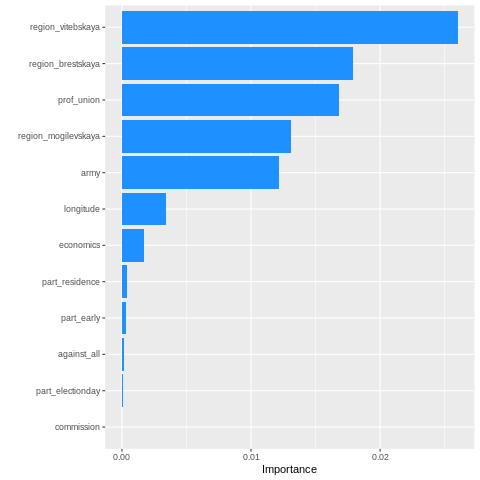

In [198]:
%%R
# backward <- step(model_lasso, direction = "backward", trace = 0)
vip(cv$glmnet.fit, width = 0.5, aesthetics = list(fill = "dodgerblue1"), num_features= 12, lambda = cv$lambda.min)

## 2. Regression model with the selected features for LASSO

Here we can see a very different performance. 
The Lasso model performs substantially better then the OLS model.
Therefore, using this method has led to better predictive performance. 
Lastly, we can also use the lasso specification for a OLS model, trained on test data to ensure that we have no incorrect standard errors.
This is a pivotal concern within in economics, because we need correct standard errors to interpret our coefficients and ensure causality. 

As a first step we can look at the coefficients in the lasso model:

In [199]:
%%R
coef_lasso <- model_lasso$beta[, which(model_lasso$lambda == lambda_lasso)]
coef_lasso

  region_brestskaya   region_gomelskaya region_grodnenskaya        region_minsk 
       2.200992e-02        0.000000e+00        0.000000e+00        0.000000e+00 
     region_miskaya region_mogilevskaya    region_no_region   region_vitebskaya 
       0.000000e+00        1.552091e-02        0.000000e+00        2.823622e-02 
              total            received           took_part          part_early 
       0.000000e+00        0.000000e+00        0.000000e+00        3.386466e-04 
     part_residence    part_electionday             dropped         against_all 
       4.206155e-04       -6.267506e-05        0.000000e+00       -1.640272e-04 
     against_single             invalid          commission             spoiled 
       0.000000e+00        0.000000e+00       -6.704417e-06        0.000000e+00 
             unused            latitude           longitude              doctor 
       0.000000e+00        0.000000e+00        3.542570e-03        0.000000e+00 
               army         

In [201]:
%%R
which(coef_lasso!=0)

  region_brestskaya region_mogilevskaya   region_vitebskaya          part_early 
                  1                   6                   8                  12 
     part_residence    part_electionday         against_all          commission 
                 13                  14                  16                  19 
          longitude                army          prof_union           economics 
                 23                  25                  28                  29 


The advantage of the lasso method is that we induce sparsity.
Here we can see that various features turn to 0.
One could also argue that due to correlation between some features, explanatory or variance was ascribed to either the one or the other variable. 
We can see that the variables that were more correlated (see correlation plot above) frequently scored 0 here. 
Now we can specify a model with the relevant coefficients, and run the model on the test data. 

In [151]:
%%R
model = lm(lukashenko_share ~  region_brestskaya +  region_mogilevskaya + region_vitebskaya + part_early+ part_residence + part_electionday + against_all + commission + longitude + army + prof_union +economics, data = set_test)  
summary(model)


Call:
lm(formula = lukashenko_share ~ region_brestskaya + region_mogilevskaya + 
    region_vitebskaya + part_early + part_residence + part_electionday + 
    against_all + commission + longitude + army + prof_union + 
    economics, data = set_test)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.63371 -0.07793  0.00978  0.08651  0.53605 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.944e-01  3.699e-02  10.663  < 2e-16 ***
region_brestskaya    6.278e-02  2.027e-02   3.096  0.00206 ** 
region_mogilevskaya  6.516e-02  2.476e-02   2.631  0.00876 ** 
region_vitebskaya    3.496e-02  2.144e-02   1.631  0.10350    
part_early           3.054e-04  2.229e-05  13.697  < 2e-16 ***
part_residence       2.704e-04  1.091e-04   2.478  0.01351 *  
part_electionday    -1.441e-04  1.781e-05  -8.090 4.15e-15 ***
against_all         -2.381e-04  1.411e-04  -1.687  0.09211 .  
commission           3.705e-06  9.205e-06   0.402  0.68748    

We can see that our R-Squared improved. 
Irrespective, various variables remain which are insignificant. 
One consideration is that feature selection via lasso regression focuses on optimizing the lasso regression and NOT an OLS regression. Henceforth, the optimization problems differ. Further, there is variation between test and train data which could also explain the outcome of some of the features. 

# 3. Exploration via unsupervised learning methods Part 1: Principal Component Analysis

In addition to supervised learning, we can also look at feature importance from the perspective of unsupervised learning.
One popular dimensionality reduction technique is principal component analysis or in short PCA. 


In [ ]:
%%R
PCA = prcomp(data, scale. = TRUE,center = TRUE)
summary(PCA)

Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     2.2102 2.0778 1.50257 1.39913 1.33834 1.23698 1.20293
Proportion of Variance 0.1576 0.1393 0.07283 0.06315 0.05778 0.04936 0.04668
Cumulative Proportion  0.1576 0.2969 0.36968 0.43282 0.49060 0.53996 0.58664
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.10224 1.09559 1.01734 1.00255 0.99884 0.96364 0.95540
Proportion of Variance 0.03919 0.03872 0.03339 0.03242 0.03218 0.02996 0.02944
Cumulative Proportion  0.62583 0.66455 0.69794 0.73036 0.76254 0.79250 0.82194
                          PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.92853 0.89491 0.84489 0.79407 0.72185 0.69192 0.58226
Proportion of Variance 0.02781 0.02583 0.02303 0.02034 0.01681 0.01544 0.01094
Cumulative Proportion  0.84976 0.87559 0.89862 0.91896 0.93577 0.95121 0.96215
                          PC22    

Typically, there are various cut-off rules both numerically, looking at the cumulative proportion of variance, but also visually using screeplots. 

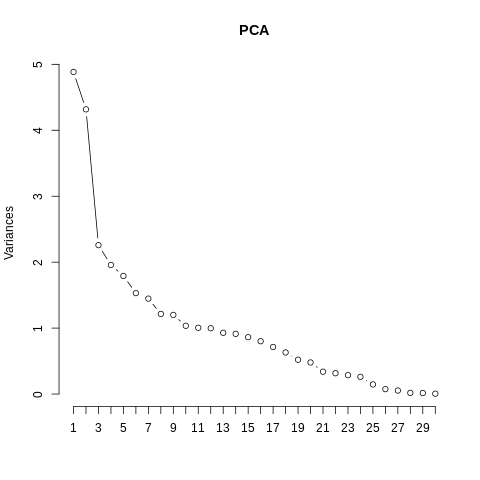

In [ ]:
%%R
screeplot(PCA, npcs =30, type = "lines")


As we can see, the variances decrease after 3 features, but still contribute up to approximately the 12th feature. Looking back at the results of the PCA, at this point we have a threshold of 0.76254. Generally speaking, a value of 0.73 is considered strong, henceforth using approximately 11 features/dimensions seems reasonable based on the PCA. These are more rules of thumb and for subsequent analysis one could explore with different cut-off points. As a reminder, we have 11 coefficients that deviate from 0 in the lasso regression model of which not all turn out to be significant. This might be a more modest estimate of how many dimensions are truely necessary here. One could argue that PCA is a useful too for exploratory data analysis prior to undertaking the regression analysis. 

## Optional: Further Analysis 

Future analysis could also use further graphical tools to examine variation in subgroups. Due to time constraints this angle is not further explored, but potentially one could also look at subgroups and interactions of different components here. The ggfortify package offers a nice plotting option for PCAs. Below you can find a plot fo the first two principal components. One can see that there are potential clusterns visible already. 

In [ ]:
%%R
install.packages("ggfortify")
library(ggfortify)

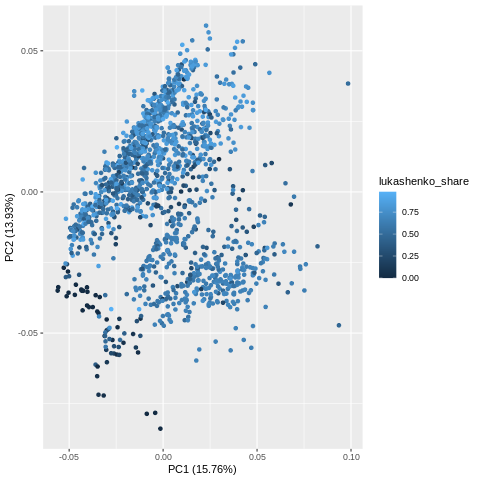

In [ ]:
%%R
autoplot(PCA, colour = "lukashenko_share", loadings =F,loading.label =T,loadings.label.size = 20, groups= data$region_minsk)


One could go even further and look at the direction of the different loadings. This would be an interesting feature for future analysis, henceforth it was included here for illustrative purposes but wont be extended here. 

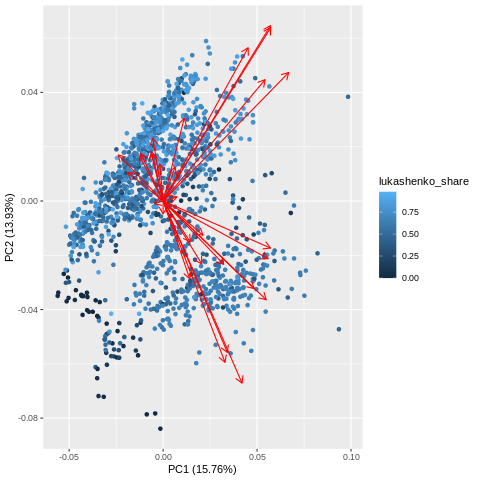

In [ ]:
%%R
autoplot(PCA, colour = "lukashenko_share", loadings =T,loading.label =T,loadings.label.size = 20)

# 4. Exploration via unsupervised learning methods Part 2: Latent Dirichlet Allocation



As suggested, one can also look topic modeling, a task within the broader field of natural language processing, focused on 

In [ ]:
%%R
system2('sudo', 'apt-get install libgsl0-dev')
install.packages("topicmodels")
install.packages("tidytext")
#install.packages("lda")
#install.packages("tm")

install.packages("reshape2")
library(reshape2)
library(tidytext)
library(topicmodels)
library(lda)
library(tm)

In [ ]:
%%R
install.packages("lda")
library(lda)

In [ ]:
%%R
data = read_excel("df_merge_n.xlsx")
data = unite(data, col = "text", commission_code:economics, sep =" ")
summary(data)

## Cleaning the Text data 


In [ ]:
%%R
data = data %>%
  select("text")

cleaner <- function(text){
  text <- tolower(text)
  text <- gsub("rt", "", text)
  text <- gsub("@\\w+", "", text)
  text <- gsub("[[:punct:]]", "", text)
  text <- gsub("http\\w+", "", text)
  text <- gsub("amp", " ", text)
  text <- gsub("[ |\t]{2,}", "", text)
  text <- gsub("^ ", "", text)
  text <- gsub(" $", "", text)
  text <- gsub(" +", " ", text)
  text <- gsub("=", " ", text)
  text <- gsub('<.*>', '', enc2native(text))
  text <- unique(text)
  return(text)
}

In [ ]:
%%R
polish <- function(text){
  text <- VCorpus(VectorSource(text))
  text <- tm_map(text, removeWords, stopwords("russian")) # used to be english, still WIP
  text <- tm_map(text, removeNumbers)
  text <- tm_map(text, stemDocument)
}

In [ ]:
%%R
text = data$text 
text <- cleaner(text)
corpus <- polish(text)

With this corpus we can create a document term matrix using the ``` DocumentTermMatrix ``` command.

In [ ]:
%%R
doc.lengths <- rowSums(as.matrix(DocumentTermMatrix(corpus)))
dtm <- DocumentTermMatrix(corpus[doc.lengths > 0])


## Setting up our Topic Model using VEM


In [ ]:
%%R
LDA_V <- LDA(dtm, k =3,method = "VEM", cotrol = list(seed=1234))
topics_1 <- tidy(LDA_V, matrix ="beta")

Next we can order the terms and select only the top 10 terms. 

In [ ]:
%%R
ap_top_terms <- topics_1 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

Now we can plot these terms using ggplot: 

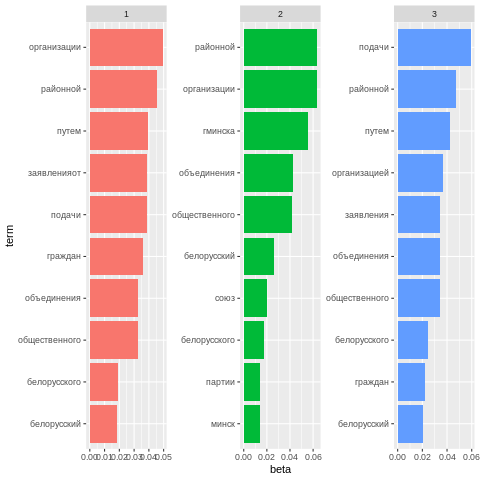

In [ ]:
%%R
ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

## Topic Model with Gibbs sampling 

We can also modify our topic model by using gibbs sampling

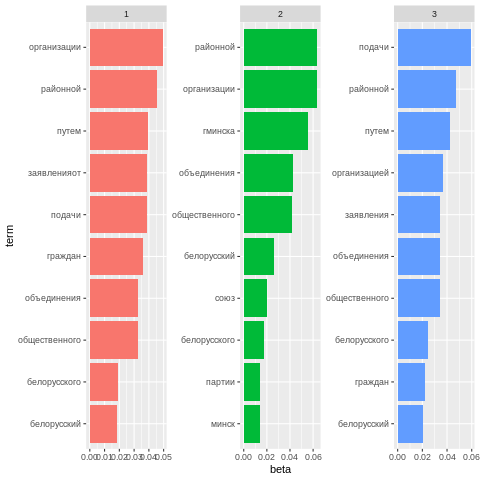

In [ ]:
%%R
LDA_G <- LDA(x=dtm, k=2, method="Gibbs",control=list(alpha=1, delta=0.1, seed=10005))
topics_2 <- tidy(LDA_V, matrix ="beta")

ap_top_terms <- topics_2 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

  ap_top_terms %>%
  mutate(term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip() +
  scale_x_reordered()

# 5.   Geospatial Analysis of Voting Behaviour 

We cal also plot the votes by area. 


In [ ]:
%%R
system('sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable')
system('sudo apt-get update')
system('sudo apt-get install libudunits2-dev libgdal-dev libgeos-dev libproj-dev')
install.packages('sf')

In [ ]:
%%R
#install.packages("rgdal")
#install.packages("sf")
library(readxl)
library(sf)

## Importing Data

In [ ]:
%%R
geo = st_read("/BLR_adm2.shp")
data <- read_excel("df_merge_no.xlsx")
geo$NAME_1[geo$NAME_1 == "Homyel'"] <- 'Homyel'
geo$NAME_1

## Feature Modifcation

We need to undertake some basic feature modifications for our datasets to merge correctly.
Here, we are looking at the data at the regional level. 
Henceforth, we need to relabel our regions so that they match with the geospatial datafile. 

In [56]:
%%R
library(stringr)
colnames(data)[3:14] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")

data$region = str_to_title(data$region)
head(geo)

data$region[data$region == 'Brestskaya'] <- 'Brest'
data$region[data$region == 'Vitebskaya'] <-'Vitsyebsk'
data$region[data$region == 'Miskaya'] <- 'Minsk'
data$region[data$region == 'Mogilevskaya'] <- "Mahilyow"
data$region[data$region == 'Gomelskaya']   <- "Homyel"
data$region[data$region == 'Grodnenskaya'] <- "Hrodna"

merge = merge(geo, data, by.x= 'NAME_1', by.y='region')
#summary(merge)


## Mapping total Voting by Area 

First of all, we can have a look at the total voting outcome in Belarus.





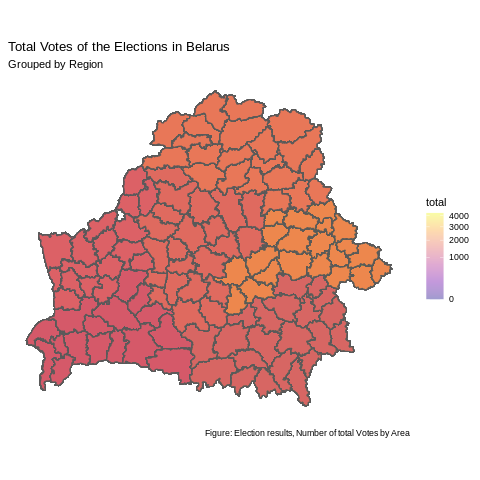

In [57]:
%%R
library(ggplot2)
plot = ggplot() + geom_sf(data= merge, mapping = aes(geometry = geometry)) + geom_sf(data = merge, mapping = aes(geometry = geometry, fill = total)) + scale_fill_viridis_c(option="C", trans = "sqrt", alpha = .4,
                      limits=c(1000, max(merge$total)))  + theme(panel.background = element_rect(fill = "white"),
        axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank()) + ggtitle("Total Votes of the Elections in Belarus",
          subtitle = "Grouped by Region") +
  labs(caption = "Figure: Election results, Number of total Votes by Area",
       x = "longitude", y = "latitude")
plot



## Share of Votes for Lukashenko

## Labels for cities 

In [58]:
%%R
capitals <- tibble::tribble( 
  ~city,           ~lat,     ~lon,
  "Brest",    52.097622, 23.734051,  
  "Minsk", 53.893009, 27.567444, 
  "Grodno",  53.669353, 23.813131, 
  "Vityebsk",  55.187222, 30.205116, 
  "Pinsk",    52.129272, 26.074677
)
capitals

# A tibble: 5 x 3
  city       lat   lon
  <chr>    <dbl> <dbl>
1 Brest     52.1  23.7
2 Minsk     53.9  27.6
3 Grodno    53.7  23.8
4 Vityebsk  55.2  30.2
5 Pinsk     52.1  26.1


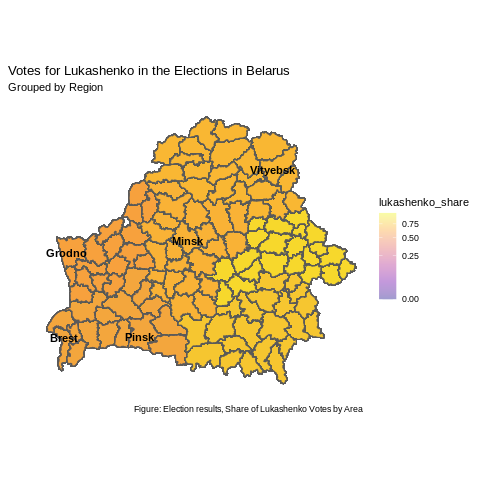

In [59]:
%%R
plot = ggplot() + geom_sf(data= merge, mapping = aes(geometry = geometry)) + geom_sf(data = merge, mapping = aes(geometry = geometry, fill = lukashenko_share)) + scale_fill_viridis_c(option="C", trans = "sqrt", alpha = .4,
                      limits=c(0.25, max(merge$lukashenko_share))) + theme(panel.background = element_rect(fill = "white"),
        axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank()) +
 geom_text(data = capitals, aes(x = lon, y = lat, label = city),   size = 3.9, col = "black", fontface = "bold") +  coord_sf(xlim = c(22, 33), ylim = c(51, 56.5), expand = FALSE) + 
 ggtitle("Votes for Lukashenko in the Elections in Belarus",
          subtitle = "Grouped by Region") +
  labs(caption = "Figure: Election results, Share of Lukashenko Votes by Area",
       x = "longitude", y = "latitude")

plot

## Election in 1994

We can also compare these results with the election results from 1994.
For the 1994, we have cleaned data and have a geospatial map at the NUTS2 level, the city level. 

In [ ]:
%%R
belarus1994_qgisNew <- read_csv("/belarus1994-qgisNew.csv")
geo = st_read("/BLR_adm2.shp")
merge = merge(geo, belarus1994_qgisNew, by.x= 'NAME_2', by.y='NAME_2')

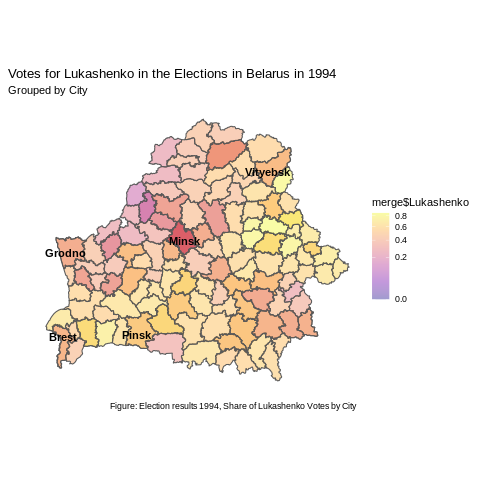

In [63]:
%%R

map = ggplot() + geom_sf(data = merge, mapping = aes(geometry = geometry, fill = merge$Lukashenko)) + scale_fill_viridis_c(option="C", trans = "sqrt", alpha = .4,
                      limits=c(0, max(merge$Lukashenko))) + theme(panel.background = element_rect(fill = "white"),
        axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank()) +
 geom_text(data = capitals, aes(x = lon, y = lat, label = city),   size = 3.9, col = "black", fontface = "bold") +  coord_sf(xlim = c(22, 33), ylim = c(51, 56.5), expand = FALSE) +
 ggtitle("Votes for Lukashenko in the Elections in Belarus in 1994",
          subtitle = "Grouped by City") +
  labs(caption = "Figure: Election results 1994, Share of Lukashenko Votes by City",
       x = "longitude", y = "latitude")
map

# Appendix
### Feature Importance Random Forest Implementation in R

In [ ]:
%%R

rfo <- ranger(lukashenko_share ~ ., data = data, importance = "permutation")
vi_rfo <- rfo$variable.importance
vi_rfo
vip(rfo, width = 0.5, aesthetics = list(fill = "green3"))

In [ ]:
%%R
data <- read_excel("df_merge_d.xlsx")

R[write to console]: New names:
* `` -> ...1



## Exclusion Regions 


In [ ]:
%%R
data = select(data, -c("Dmitriev","Kanopatskaya","Lukashenko","Tikhanovskaya","Cherechen")) # removing other candidate votes
data = select(data, -c("region_no_region", "number_of_votes_against_a_candidate_if_voting_was_held_on_one_candidate","...1" ))
colnames(data)[1:12] = c("total", "received","took_part","part_early","part_residence","part_electionday", "dropped","against_all","invalid","commission","spoiled","unused")

In [ ]:
%%R
data = data %>%
na.omit(lukashenko_share ==0)
data$lukashenko_share
p = ncol(data) -1
n <- nrow(data)
ind_train = sample(x = 1:n, size = ceiling(0.66 * n))
set_train = data[ind_train,]
ind_test = setdiff(x=1:n, ind_train)
set_test = data[ind_test,] 

model_naive_all_b_minsk = lm(lukashenko_share~.- region_minsk, data = set_train)
model_naive_none = lm(lukashenko_share~.- region_minsk -region_brestskaya - region_grodnenskaya - region_gomelskaya-region_minsk-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_none_b_minsk = lm(lukashenko_share~. -region_br

In [ ]:
%%R

estskaya - region_grodnenskaya - region_gomelskaya-region_miskaya -region_mogilevskaya- region_vitebskaya, data = set_train)
model_naive_all = lm(lukashenko_share~., data = set_train)

## Analysis of Variance for the dummy variables

In [ ]:
%%R
#export_summs(model_naive, model_naive_m)
anova(model_naive_none, model_naive_none_b_minsk, model_naive_all_b_minsk, model_naive_all)